# Assignment 4
### Do three of six.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [2]:
df = pd.read_csv('data/mn_police_use_of_force.csv')
df.shape

(12925, 13)

In [3]:
df['subject_injury'].unique()

array([nan, 'No', 'Yes'], dtype=object)

In [4]:
df['race'].unique()

array(['Black', 'White', 'Native American', nan, 'Other / Mixed Race',
       'Asian', 'Pacific Islander'], dtype=object)

In [5]:
pd.crosstab(df['subject_injury'], df['race'], normalize=True)

race,Asian,Black,Native American,Other / Mixed Race,White
subject_injury,,,,,
No,0.004998,0.323559,0.028657,0.015995,0.100300
Yes,0.010663,0.290237,0.044652,0.024325,0.156614


In [9]:
pd.crosstab(df['subject_injury'].isna(), df['race'], normalize=True)

race,Asian,Black,Native American,Other / Mixed Race,Pacific Islander,White
subject_injury,,,,,,
False,0.003949,0.154777,0.018486,0.010167,0.000000,0.064784
True,0.006890,0.487858,0.047391,0.007058,0.000504,0.198135


In [6]:
sum(df['subject_injury'].isna())

9848

/var/folders/zb/h91tjjld33j5nbqghqy9_xsm0000gn/T/ipykernel_50215/386611908.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


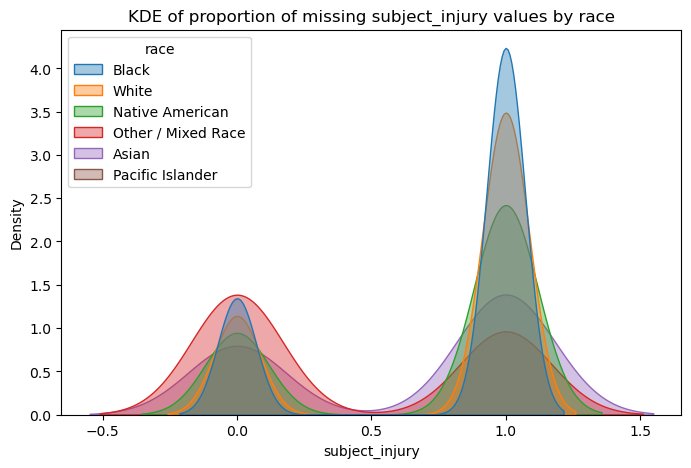

In [18]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df,
    x=df['subject_injury'].isna(),
    hue='race',
    common_norm=False,   # each race density integrates to 1
    fill=True,           # optional: shaded curves
    alpha=0.4
)
plt.title("KDE of proportion of missing subject_injury values by race")
plt.show()

In [10]:
def simulate(var, df, race, S=1000):
    """Bootstrap simulation code. Returns an array of bootstrap means for one race."""
    x = df[var].loc[df['race'] == race]

    estimates = []
    for s in range(S):
        x_s = x.sample(frac=1.0, replace=True)
        # your statistic: mean of the indicator; keep as-is if that's intended
        stat_s = np.mean(x_s.isna())      # <-- if you actually meant a mean of values, change to np.mean(x_s)
        estimates.append(stat_s)

    return np.array(estimates)

In [11]:
all_rows = []
for r in df['race'].dropna().unique():   # drop NaN if you don’t want a “nan” hue
    est = simulate('subject_injury', df, r, S=1000)
    # long-format rows: one estimate per row, tagged by race
    all_rows.append(pd.DataFrame({'race': r, 'estimate': est}))

estimates_df = pd.concat(all_rows, ignore_index=True)

/var/folders/zb/h91tjjld33j5nbqghqy9_xsm0000gn/T/ipykernel_50215/1486828683.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


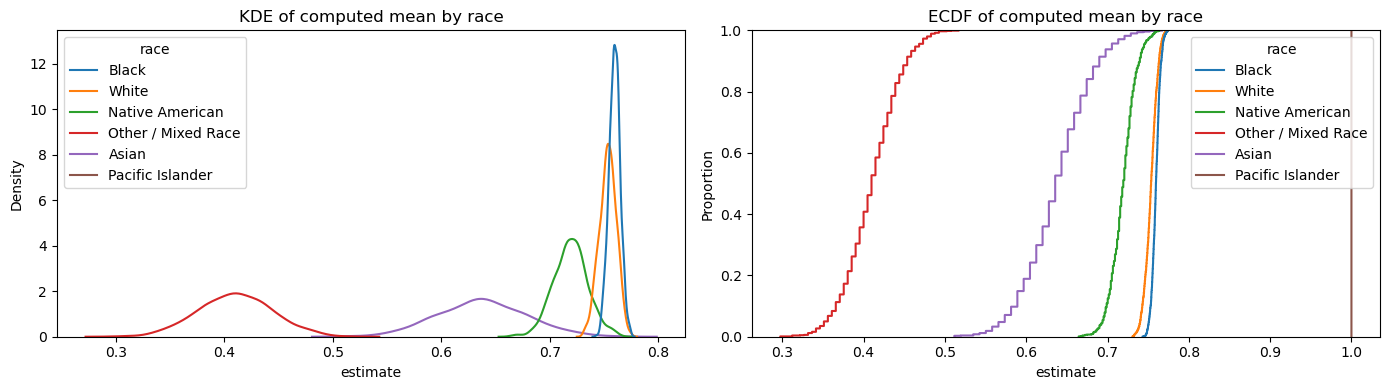

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# KDE of the bootstrap means
sns.kdeplot(
    data=estimates_df,
    x='estimate',
    hue='race',
    ax=ax[0]
).set(title='KDE of computed mean by race')

# ECDF of the bootstrap means
sns.ecdfplot(
    data=estimates_df,
    x='estimate',
    hue='race',
    ax=ax[1]
).set(title='ECDF of computed mean by race')

plt.tight_layout()
plt.show()

The distributions are not the same across groups. For plots of black and white missing data, the mean has a lower variance and the distribution is more tightly centered. The higher variance among the other races indicates sensitivity to the analytical approach. At the extreme end, victims coded as Pacific Islanders have exclusively missing data for subject_injury, so the resample for the ECDF is 1.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference